# AutoEncoders

## Introduction

Explore autoencoders first in numpy, then in keras (you can swithch the backend to pytorch or jax when ready).

We look at a PCA, a linear autoencoder, and then a two layer autoencoder in `numpy`.

Then a (flexible) AutoEncoder in keras. Then some hyperparameter tuning based on a suitable metric.

## Data

Example data from [here](https://huggingface.co/datasets/simecek/human_nontata_promoters), more details [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0171410#sec002)

It's human nontata promoters toy dataset.

https://chatgpt.com/share/67227fc5-2688-8011-bb2e-e9095ce89d41



In [ ]:
import pandas as pd
import numpy as np

splits = {'train': 'data/train-00000-of-00001-9af6936029261ba1.parquet', 'test': 'data/test-00000-of-00001-5ba65be5fd0fb68f.parquet'}
df = pd.read_parquet("hf://datasets/simecek/human_nontata_promoters/" + splits["train"])
df = df.rename(columns={"seq": "sequence"})


In [ ]:
df.head()

,labels,sequence
0,0,ACAGATTCAGGATGTCCTGTCGGGGCATGGACCCTGGAAAGCTGCG...
1,0,ATGATTTTAATACCACATTGGTAGACCTGCAATCCCCCAGAGAAGG...
2,0,CCCCGGGATGCCCCTAGCCCCTCCCTGTGAGCTGCCTCTCACAGGT...
3,0,GACCACCAGGGTGAGCTGGGGGTGGGCGGGGCCTGCCTGGCCAGGG...
4,0,TTTTCCAGAAAATGAGGTGTGGCCAAACATCTTCAGGCTTTTCCTT...


In [ ]:
# Summary statistics
print(df['sequence'].describe())

count                                                 27097
unique                                                27097
top       ACAGATTCAGGATGTCCTGTCGGGGCATGGACCCTGGAAAGCTGCG...
freq                                                      1
Name: sequence, dtype: object


In [ ]:
unique_characters = set().union(*df['sequence'])
print(f"Unique characters: {unique_characters}")

Unique characters: {'T', 'G', 'A', 'C'}


In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_sequence_encoder(sequence_series):
    """
    Creates and returns a OneHotEncoder for DNA sequences.

    Parameters:
    sequence_series (pd.Series): Series containing DNA sequences.

    Returns:
    OneHotEncoder: Fitted OneHotEncoder instance for the given sequences.
    """
    # Define fixed categories for each character position
    categories = ['A', 'C', 'G', 'T']

    # Determine the sequence length (assuming all sequences have the same length)
    sequence_length = len(sequence_series.iloc[0])

    # Initialize the OneHotEncoder with fixed categories for each position
    one_hot_encoder = OneHotEncoder(categories=[categories] * sequence_length,
                                    handle_unknown='ignore',
                                    dtype=int,
                                    sparse_output=False)

    # Fit the encoder to the sequences
    one_hot_encoder.fit(sequence_series.apply(list).tolist())

    return one_hot_encoder


encoder = one_hot_sequence_encoder(df['sequence'])

# Encode sequences
encoded_sequences = encoder.transform(df['sequence'].apply(list).tolist())

# Decode sequences
decoded_sequences = encoder.inverse_transform(encoded_sequences)

# Check equivalence
is_equivalent = (decoded_sequences == df['sequence'].apply(list).tolist()).all()

print("Original sequences: \n", df['sequence'].apply(list).tolist()[:20])
print("Encoded sequences:\n", encoded_sequences)
print("\nDecoded Sequences:\n", decoded_sequences)
print("\nAre the original and decoded sequences equivalent?", is_equivalent)

Original sequences: 
 [['A', 'C', 'A', 'G', 'A', 'T', 'T', 'C', 'A', 'G', 'G', 'A', 'T', 'G', 'T', 'C', 'C', 'T', 'G', 'T', 'C', 'G', 'G', 'G', 'G', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'C', 'C', 'T', 'G', 'G', 'A', 'A', 'A', 'G', 'C', 'T', 'G', 'C', 'G', 'G', 'A', 'C', 'A', 'C', 'C', 'A', 'G', 'G', 'A', 'G', 'G', 'G', 'C', 'A', 'G', 'G', 'C', 'A', 'A', 'G', 'A', 'G', 'A', 'G', 'T', 'C', 'T', 'C', 'A', 'T', 'C', 'T', 'C', 'T', 'T', 'G', 'C', 'T', 'C', 'C', 'C', 'T', 'A', 'G', 'G', 'A', 'G', 'C', 'T', 'A', 'T', 'G', 'A', 'G', 'T', 'T', 'G', 'A', 'G', 'G', 'G', 'C', 'G', 'C', 'C', 'G', 'T', 'C', 'T', 'G', 'A', 'G', 'C', 'A', 'G', 'G', 'A', 'G', 'G', 'G', 'A', 'C', 'G', 'G', 'A', 'C', 'G', 'G', 'G', 'T', 'G', 'C', 'C', 'C', 'A', 'G', 'G', 'G', 'T', 'T', 'T', 'G', 'A', 'G', 'G', 'A', 'A', 'A', 'G', 'A', 'G', 'G', 'G', 'G', 'T', 'G', 'T', 'G', 'G', 'G', 'A', 'A', 'G', 'G', 'A', 'C', 'G', 'C', 'A', 'T', 'G', 'C', 'T', 'A', 'G', 'A', 'A', 'C', 'T', 'T', 'C', 'A', 'G', 'A', 'G', 'C', 'A', 'G', '

In [ ]:
# Assuming 'df' and 'encoded_sequences' are already defined as in your provided code

# Check if all encoded sequences lengths are divisible by 4 and print out if they are all equal
sequence_lengths = [len(seq) for seq in encoded_sequences]

all_divisible_by_4 = all(length % 4 == 0 for length in sequence_lengths)
print("Are all encoded sequences divisible by 4?", all_divisible_by_4)


if all_divisible_by_4:
    all_lengths_equal = all(length == sequence_lengths[0] for length in sequence_lengths)
    print("Are all sequence lengths equal?", all_lengths_equal)

    # Calculate and print the length of the original sequences
    if all_lengths_equal:
      print("Length of sequences:", sequence_lengths[0] // 4)

    # Add a new column to the dataframe with the lengths of the original sequences.
    df['sequence_length'] = sequence_lengths[0] // 4

#Example of accessing the sequence lengths
#print("Sequence lengths in df:", df['sequence_length'])

Are all encoded sequences divisible by 4? True
Are all sequence lengths equal? True
Length of sequences: 251


In [ ]:
data = encoded_sequences

## SimplePCA

In [ ]:
class SimplePCA:
    def __init__(self, n_components):
        """
        Initialize PCA with the number of principal components.

        Parameters:
        n_components (int): Number of principal components to keep.
        """
        self.n_components = n_components  # Number of principal components to keep
        self.mean = None  # Mean of the input data
        self.components = None  # Principal components (eigenvectors)

    def fit(self, X):
        """
        Fit the PCA model to the data.

        Parameters:
        X (np.ndarray): Input data matrix with shape (n_samples, n_features).
        """
        # Step 1: Center the data by subtracting the mean
        self.mean = np.mean(X, axis=0)  # Compute the mean of each feature
        X_centered = X - self.mean  # Center the data

        # Step 2: Compute the covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)  # Covariance matrix

        # Step 3: Compute the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)  # Eigen decomposition using eigh for symmetric matrices

        # Step 4: Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]  # Indices of sorted eigenvalues
        self.components = eigenvectors[:, sorted_indices[:self.n_components]]  # Top components

    def _encode(self, X):
        """
        Project the data onto the principal components (latent space).

        Parameters:
        X (np.ndarray): Input data matrix with shape (n_samples, n_features).

        Returns:
        np.ndarray: Transformed data in the latent space.
        """
        X_centered = X - self.mean  # Center the data
        return np.dot(X_centered, self.components)  # Project onto the principal components

    def _decode(self, Z):
        """
        Reconstruct the original data from the latent representation.

        Parameters:
        Z (np.ndarray): Latent representation of the data.

        Returns:
        np.ndarray: Reconstructed data in the original space.
        """
        return np.dot(Z, self.components.T) + self.mean  # Project back to original space

    def transform(self, X):
        """
        Transform the data using the encoder.

        Parameters:
        X (np.ndarray): Input data matrix with shape (n_samples, n_features).

        Returns:
        np.ndarray: Transformed data in the latent space.
        """
        return self._encode(X)  # Encode the data to latent space

    def fit_transform(self, X):
        """
        Fit the PCA model and transform the data in one step.

        Parameters:
        X (np.ndarray): Input data matrix with shape (n_samples, n_features).

        Returns:
        np.ndarray: Transformed data in the latent space.
        """
        self.fit(X)  # Fit the model
        return self.transform(X)  # Transform the data

In [ ]:
    # Create dummy data (e.g., 100 samples, 5 features)
    np.random.seed(0)

    # Create and fit the PCA model
    pca = SimplePCA(n_components=2)  # Reduce to 2 dimensions
    reduced_data = pca.fit_transform(data)  # Fit and transform the data

    # Reconstruct the original data from the reduced representation
    reconstructed_data = pca._decode(reduced_data)

    print("Original Data Shape:", data.shape)
    print("Reduced Data Shape:", reduced_data.shape)
    print("Reconstructed Data Shape:", reconstructed_data.shape)
    print("Reconstructed Data:\n", reconstructed_data)

Original Data Shape: (27097, 1004)
Reduced Data Shape: (27097, 2)
Reconstructed Data Shape: (27097, 1004)
Reconstructed Data:
 [[0.23405211 0.22989363 0.33168709 ... 0.24791748 0.36568574 0.17303996]
 [0.28420048 0.192248   0.20963985 ... 0.19645512 0.22256865 0.30349578]
 [0.1651022  0.34325704 0.30716904 ... 0.33306012 0.34516367 0.16872342]
 ...
 [0.21936379 0.26889721 0.28009107 ... 0.2695241  0.3089194  0.21432839]
 [0.14112689 0.36577753 0.35139902 ... 0.35871977 0.39763348 0.11920528]
 [0.15470422 0.34608316 0.34802045 ... 0.3425677  0.39240241 0.12752477]]


### PCA to Sequence Predictor

In [ ]:
from sklearn.preprocessing import LabelBinarizer

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # Subtract max for numerical stability
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def predict_sequence(reconstructed_data):
    # Assuming reconstructed_data is a NumPy array where each row represents a sequence
    # and each four columns represent a letter.
    num_sequences = reconstructed_data.shape[0]
    sequence_length = reconstructed_data.shape[1] // 4  # Calculate the sequence length
    predicted_sequences = []

    for i in range(num_sequences):
        sequence_probs = reconstructed_data[i].reshape(sequence_length, 4)  # Reshape for softmax per letter
        # Apply softmax
        probabilities = softmax(sequence_probs)
        # Get hard predictions (indices of max probability)
        hard_predictions = np.argmax(probabilities, axis=1)

        # Map indices back to characters
        characters = ['A', 'C', 'G', 'T']
        predicted_sequence = ''.join(characters[idx] for idx in hard_predictions)
        predicted_sequences.append(predicted_sequence)

    return predicted_sequences




In [ ]:
# Example usage (assuming 'reconstructed_data' is available)
# Assuming reconstructed_data is available from previous code execution
predicted_seqs = predict_sequence(reconstructed_data)
predicted_seqs[:10]

['GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG',
 'TTTTTTTTTTTTTTTTTTTTTTTATTTTTTTTTTTTTTTTTTTTTTTTTTATTTAATTTTATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTTTTTTTTTTTTTTTTTTTTTATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTATAATTTTTTTTTTTTTTTTTTTATTTATATTTTTTTTTTTTTTTTTTTTT',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGCCAGGGGCGGCGGCGGGCCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGGG',
 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCAGGGGGGGGGGGGGGGGGGGGGGGGGGGGG

## Simple Linear AutoEncoder

In [ ]:
import numpy as np

class SimpleLinearAutoencoder:
    def __init__(self, input_dim, latent_dim):
        # Initialize the autoencoder with input and latent dimensions
        self.input_dim = input_dim  # Dimension of input data
        self.latent_dim = latent_dim  # Dimension of latent space (z)

        # Weights for the encoder (e) and decoder (d)
        self.weights_e = np.random.randn(input_dim, latent_dim) * 0.01  # Encoder weights
        self.weights_d = np.random.randn(latent_dim, input_dim) * 0.01  # Decoder weights

    def encode(self, X):
        # Encode input data to latent space
        return np.dot(X, self.weights_e)  # Linear transformation to latent space

    def decode(self, z):
        # Decode latent space back to original space
        return np.dot(z, self.weights_d)  # Linear transformation to reconstruct input

    def fit(self, X, epochs=1000, learning_rate=0.01):
        # Train the autoencoder using gradient descent
        for epoch in range(epochs):
            # Encode input data
            z = self.encode(X)  # Latent representation

            # Decode to reconstruct input
            X_hat = self.decode(z)  # Reconstructed input

            # Calculate the loss (mean squared error)
            loss = np.mean((X - X_hat) ** 2)

            # Compute gradients for encoder and decoder weights
            d_loss = -2 * (X - X_hat) / X.shape[0]  # Gradient of loss w.r.t reconstruction
            grad_d = np.dot(z.T, d_loss)  # Gradient for decoder weights
            grad_e = np.dot(X.T, np.dot(d_loss, self.weights_d.T))  # Gradient for encoder weights

            # Update weights using gradient descent
            self.weights_d -= learning_rate * grad_d  # Update decoder weights
            self.weights_e -= learning_rate * grad_e  # Update encoder weights

            # Print the loss every 100 epochs
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')

    def predict(self, X):
        # Predict using the autoencoder (reconstruct input)
        z = self.encode(X)  # Encode input to latent space
        return self.decode(z)  # Decode back to original space


In [ ]:
execute_slow_code = False
if execute_slow_code:
    # Create and train the autoencoder
    num_features = data.shape[1]
    autoencoder = SimpleLinearAutoencoder(input_dim=num_features, latent_dim=2)
    autoencoder.fit(data, epochs=1000, learning_rate=0.01)

    # Predict (reconstruct) the input data
    reconstructed_data = autoencoder.predict(data)

    print("Original Data:\n", data)
    print("Reconstructed Data:\n", reconstructed_data)

## Two Layer AutoEncoder

In [ ]:
class TwoLayerAutoencoder:
    def __init__(self, input_dim, hidden_dim):
        # Initialize the autoencoder with input and hidden layer dimensions
        self.input_dim = input_dim  # Dimension of input data
        self.hidden_dim = hidden_dim  # Dimension of hidden layer
        # Initialize weights and biases for encoder and decoder
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01  # Weights for encoder
        self.b1 = np.zeros((1, hidden_dim))  # Bias for encoder
        self.W2 = np.random.randn(hidden_dim, input_dim) * 0.01  # Weights for decoder
        self.b2 = np.zeros((1, input_dim))  # Bias for decoder

    def _sigmoid(self, x):
        """Sigmoid activation function."""
        return 1 / (1 + np.exp(-x))

    def _sigmoid_derivative(self, x):
        """Derivative of the sigmoid function."""
        return x * (1 - x)

    def fit(self, X, epochs=1000, learning_rate=0.01):
        # Fit the autoencoder model to the data
        for epoch in range(epochs):
            # Forward pass (encoding)
            hidden = self._sigmoid(np.dot(X, self.W1) + self.b1)  # Hidden layer output (encoder)
            # Forward pass (decoding)
            output = self._sigmoid(np.dot(hidden, self.W2) + self.b2)  # Reconstructed output (decoder)

            # Calculate the reconstruction error
            error = output - X  # Difference between output and original input
            # Backpropagation
            output_gradient = error * self._sigmoid_derivative(output)  # Gradient for output layer

            # Update decoder weights and biases
            self.W2 -= learning_rate * np.dot(hidden.T, output_gradient)  # Update W2
            self.b2 -= learning_rate * np.sum(output_gradient, axis=0, keepdims=True)  # Update b2

            # Calculate hidden layer error
            hidden_error = np.dot(output_gradient, self.W2.T)  # Backpropagated error to hidden layer
            hidden_gradient = hidden_error * self._sigmoid_derivative(hidden)  # Gradient for hidden layer

            # Update encoder weights and biases
            self.W1 -= learning_rate * np.dot(X.T, hidden_gradient)  # Update W1
            self.b1 -= learning_rate * np.sum(hidden_gradient, axis=0, keepdims=True)  # Update b1

            # Optional: print the error at intervals
            if epoch % 100 == 0:
                loss = np.mean(np.square(error))  # Mean squared error
                print(f'Epoch {epoch}, Loss: {loss:.4f}')

    def predict(self, X):
        """Reconstruct the input data from the encoded representation."""
        hidden = self._sigmoid(np.dot(X, self.W1) + self.b1)  # Encode the input
        output = self._sigmoid(np.dot(hidden, self.W2) + self.b2)  # Decode the hidden representation
        return output  # Return the reconstructed data



In [ ]:
execute_slow_code = False
if execute_slow_code:
    # Create and fit the autoencoder model
    num_features = data.shape[1]
    autoencoder = TwoLayerAutoencoder(input_dim=num_features, hidden_dim=3)  # 3-dimensional hidden layer
    autoencoder.fit(data, epochs=1000, learning_rate=0.01)  # Fit the model

    # Reconstruct the original data using the autoencoder
    reconstructed_data = autoencoder.predict(data)

    print("Original Data Shape:", data.shape)
    print("Reconstructed Data Shape:", reconstructed_data.shape)
    print("Reconstructed Data:\n", reconstructed_data)

## Keras AutoEncoder

This is a keras based autoencoder. Please change the backend runtime to the best GPU/TPU.

You can read more on TPUs [here](https://chatgpt.com/share/67227788-185c-800c-900b-78579167b503)


You can read through docs and change the backend to tensorflow, pytorch or jax.

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense

def create_autoencoder(input_dim, encoding_dims):
    """
    Create an autoencoder model with variable hidden layers.

    Parameters:
    input_dim (int): Dimension of the input data.
    encoding_dims (list): List of integers representing the number of neurons in each hidden layer.

    Returns:
    Model: Compiled autoencoder model.
    """
    # Encoder
    input_layer = Input(shape=(input_dim,))
    x = input_layer
    for dim in encoding_dims:
        x = Dense(dim, activation='relu')(x)

    # Decoder
    for dim in reversed(encoding_dims[:-1]):
        x = Dense(dim, activation='relu')(x)
    decoded = Dense(input_dim, activation='softmax')(x)

    # Autoencoder
    autoencoder = Model(input_layer, decoded)

    return autoencoder

### Example Without Tuning


In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from keras.metrics import Precision, Recall, Accuracy
import tensorflow as tf

input_dim = data.shape[1]
encoding_dims = [128, 64, 32]  # Example hidden layers
autoencoder = create_autoencoder(input_dim, encoding_dims)

# Initialize the RMSProp optimizer with a learning rate of 0.01
rmsprop_optimizer = RMSprop(learning_rate=0.1)

# Custom callback to print progress every 5 epochs
class PrintProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}, val_loss = {logs['val_loss']}")

# Custom metric for F1 score
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Compile the autoencoder with the custom optimizer and additional metrics
autoencoder.compile(optimizer=rmsprop_optimizer, loss='categorical_crossentropy', metrics=[F1Score(), Precision(), Recall(), Accuracy()])

# Train the autoencoder with the custom progress callback
autoencoder.fit(data, data, epochs=50, batch_size=32, validation_split=0.2, callbacks=[PrintProgress()])

Epoch 1/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7414 - f1_score: 0.8715 - loss: 379726420975045050368.0000 - precision_1: 0.2642 - recall_1: 0.0010 - val_accuracy: 0.7492 - val_f1_score: 0.8896 - val_loss: 7688467033803385208832.0000 - val_precision_1: 0.1804 - val_recall_1: 7.1890e-04
Epoch 2/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7493 - f1_score: 0.8713 - loss: 15634427376301678526464.0000 - precision_1: 0.2691 - recall_1: 0.0011 - val_accuracy: 0.7493 - val_f1_score: 0.8896 - val_loss: 35397347315210350755840.0000 - val_precision_1: 0.3201 - val_recall_1: 0.0013
Epoch 3/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7493 - f1_score: 0.8727 - loss: 45814736203271729315840.0000 - precision_1: 0.2670 - recall_1: 0.0011 - val_accuracy: 0.7493 - val_f1_score: 0.8896 - val_loss: 60274974951626210541568.0000 - val_precision_1: 0.3373 - val_recall_1: 0.0013
Epoch 4/50
678/678 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7493 - f1_score:

847/847 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


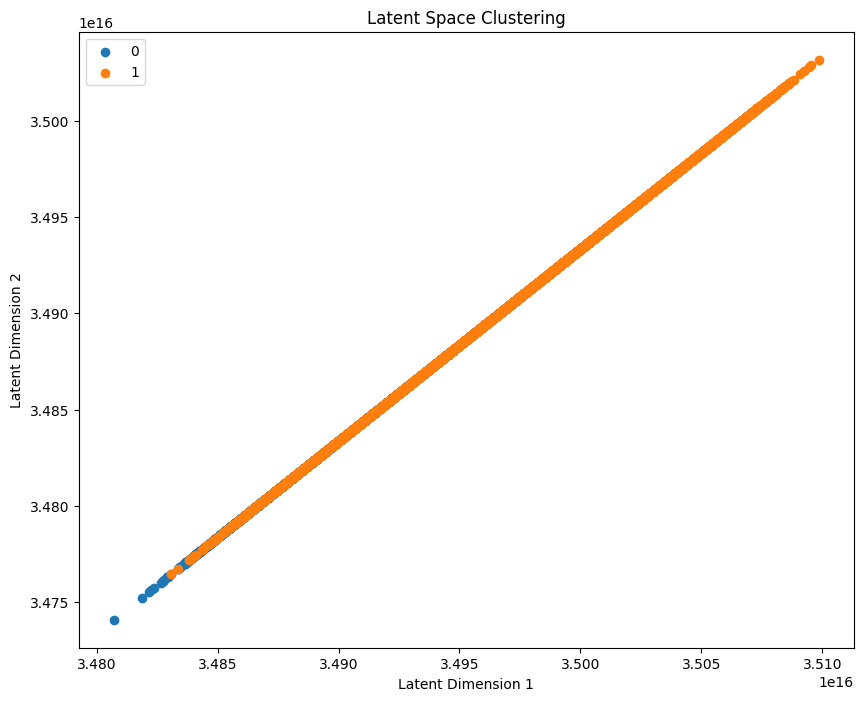

In [ ]:
# prompt: Display how the latent space of the autoencoder clusters. You can use the labels from the dataframe to color the clustering.

import matplotlib.pyplot as plt

# Assuming 'autoencoder' is your trained Keras autoencoder and 'data' is your input data
# Get the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output) # Adjusted to get the second-to-last layer

# Encode the data to get the latent space representation
latent_space = encoder.predict(data)

# Assuming 'df' is your DataFrame with labels
labels = df['labels'].values # Access labels from your dataframe

# Create a scatter plot of the latent space, coloring points by their labels
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(latent_space[indices, 0], latent_space[indices, 1], label=label)

plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Clustering")
plt.legend()
plt.show()

### Hyperparameter Training

In [ ]:
!pip -q install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
import optuna
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from keras.metrics import Precision, Recall, Accuracy
import tensorflow as tf

# Custom callback to print progress every 5 epochs
class PrintProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}, val_loss = {logs['val_loss']}")

# Custom metric for F1 score
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    encoding_dims = [trial.suggest_int(f'n_units_l{i}', 8, 512) for i in range(num_layers)]

    # Create the autoencoder model
    autoencoder = create_autoencoder(input_dim, encoding_dims)

    # Initialize the RMSProp optimizer with the suggested learning rate
    rmsprop_optimizer = RMSprop(learning_rate=learning_rate)

    # Compile the autoencoder with the custom optimizer and additional metrics
    autoencoder.compile(optimizer=rmsprop_optimizer, loss='mse', metrics=[F1Score(), Precision(), Recall(), Accuracy()])

    # Train the autoencoder with the custom progress callback
    history = autoencoder.fit(data, data, epochs=50, batch_size=32, validation_split=0.2, callbacks=[PrintProgress()], verbose=0)

    # Return the validation loss as the objective value
    return history.history['val_loss'][-1]

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

### Check Predictions